In [81]:
!pip install -U image-classifiers
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mount Drive 
* change working directory

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
cd /content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/

/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local


In [84]:
ls -la

total 13
-rw------- 1 root root  249 Jan  7 08:36 config.json
drwx------ 2 root root 4096 Jan  6 21:17 coreLib/
drwx------ 2 root root 4096 Jan  7 08:37 covid_19_pneumonia_tuberculosis/
drwx------ 6 root root 4096 Jan  7 16:37 models/


# PARAMETERS
**BEFORE YOU START**

> Indented block


* **Kaggle dataset GCS path** from kaggle dataset
* **UPLOAD DATA CONFIG**

**SET THE FOLLOWING VARIABLES**
```python
  GCS_PATH    :    The raw path of kaggle gcs 
  EPOCHS      :    number of epochs  
  BUFFER_SIZE :    shuffle size of the buffer    
  MODEL_NAME  :    name of the saved model
  TF_IDEN     :    name of the zipped folder
  DATA_FOLDER :    tfrecords folder
``` 

In [85]:
import os 
GCS_PATH    =    'gs://kds-3e43dc9051dbb77874e2b92bb0ceeeab3064049538e89c1d7d9d41d6'
MODEL_NAME  =    "inceptionresnetv2" # @param ["vgg16","vgg19","resnet18","resnet34","resnet50","resnet101","resnet152","resnet50v2","resnet101v2","resnet152v2","resnext50","resnext101","densenet121","densenet169","densenet201","inceptionv3","xception","inceptionresnetv2","seresnet18","seresnet34","seresnet50","seresnet101","seresnet152","seresnext50","seresnext101","senet154","nasnetlarge","nasnetmobile","mobilenet","mobilenetv2"]
DATA_FOLDER =    "content/drive/MyDrive/covid_19_pneumonia_tuberculosis/data/tfrecords"
EPOCHS      =    250   # @param
BUFFER_SIZE =    2048  
MODEL_DIR =    os.path.join(os.getcwd(),"models",f'{MODEL_NAME}') 

if not os.path.exists(MODEL_DIR):
   os.mkdir(MODEL_DIR)

WEIGHT_PATH=os.path.join(MODEL_DIR,f"{MODEL_NAME}.h5")
GCS_PATH    =    f'{GCS_PATH}/{DATA_FOLDER}'
print(GCS_PATH)
print(WEIGHT_PATH)

gs://kds-3e43dc9051dbb77874e2b92bb0ceeeab3064049538e89c1d7d9d41d6/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/data/tfrecords
/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/models/inceptionresnetv2/inceptionresnetv2.h5


# Config Reading

In [86]:
import json

with open('config.json') as f:
  config = json.load(f)

IMAGE_TYPE =  config['image_type']
IMG_DIM    =  config['img_dim']
LABELS     =  config['labels']
NB_CHANNEL =  config['nb_channels']
NB_CLASSES =  config['nb_classes']
NB_TRAIN   =  config['nb_train_data']
NB_EVAL    =  config['nb_eval_data']

config

{'image_type': 'rgb',
 'img_dim': 256,
 'labels': ['covid_19', 'normal', 'pneumonia', 'tuberculosis'],
 'nb_channels': 3,
 'nb_classes': 4,
 'nb_eval_data': 7194,
 'nb_train_data': 18180}

# DEFAULT OPS: TPU TFrecords

## TPU initialize

In [87]:
import tensorflow as tf 
import os 


print(tf.__version__)
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

2.9.2
Running on TPU  grpc://10.8.224.194:8470


REPLICAS:  8


## Training Params

In [88]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = NB_TRAIN//BATCH_SIZE
EVAL_STEPS      = NB_EVAL//BATCH_SIZE
print(STEPS_PER_EPOCH,EVAL_STEPS)

142 56


## Data input function

In [89]:
def data_input_fn(mode): 
    '''
      This Function generates data from gcs
    '''
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature((),tf.string) ,
                    'label'  : tf.io.FixedLenFeature((),tf.int64)
        }    
        parsed_example=tf.io.parse_single_example(example,feature)
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=NB_CHANNEL)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(IMG_DIM,IMG_DIM,NB_CHANNEL))
        
        idx = tf.cast(parsed_example['label'], tf.int32)
        label=tf.one_hot(idx,NB_CLASSES,dtype=tf.float32)
        return image,label

    gcs_pattern=os.path.join(GCS_PATH,mode,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Data Check

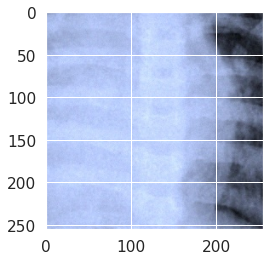

Exception ignored in: <function Executor.__del__ at 0x7f59f13f40d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Image Batch Shape: (128, 256, 256, 3)
Target Batch Shape: (128, 4)
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


In [90]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_ds  =   data_input_fn("train")
eval_ds   =   data_input_fn("eval")


for x,y in eval_ds.take(1):
    data=np.squeeze(x[0])
    plt.imshow(data)
    plt.show()
    print('Image Batch Shape:',x.shape)
    print('Target Batch Shape:',y.shape)
    print(y[0])

# MODEL definition
**THIS IS CHANGEABLE**

## Callbacks
**CHANGABLE**

In [91]:

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-7)

mode_autosave = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH,
                                                  save_best_only=True, 
                                                  verbose=1, 
                                                  period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, 
                                                  verbose=1, 
                                                  mode = 'auto') 

callbacks = [mode_autosave, lr_reducer,early_stopping ]

In [92]:
from classification_models.tfkeras import Classifiers
with strategy.scope():
    classifier, _ = Classifiers.get(MODEL_NAME)
    net=classifier(input_shape=(IMG_DIM,IMG_DIM,NB_CHANNEL),include_top=False)
    inp=net.input
    x=net.output
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    x=tf.keras.layers.Dense(NB_CLASSES,activation="softmax")(x)
    model=tf.keras.Model(inputs=inp,outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

model.summary()

219055592/219055592 [==============================] - 3s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1197 (Conv2D)           (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_108 (Batch  (None, 127, 127, 32  96         ['conv2d_1197[0][0]']            
 Normalization)          

In [93]:
history = model.fit(train_ds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1, 
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS,
                    callbacks=callbacks)

Epoch 1/250
142/142 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.8860
Epoch 1: val_loss improved from inf to 0.53901, saving model to /content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/models/inceptionresnetv2/inceptionresnetv2.h5
142/142 [==============================] - 234s 521ms/step - loss: 0.3018 - accuracy: 0.8860 - val_loss: 0.5390 - val_accuracy: 0.8590 - lr: 1.0000e-04
Epoch 2/250
142/142 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9793
Epoch 2: val_loss improved from 0.53901 to 0.44390, saving model to /content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/models/inceptionresnetv2/inceptionresnetv2.h5
142/142 [==============================] - 59s 419ms/step - loss: 0.0609 - accuracy: 0.9793 - val_loss: 0.4439 - val_accuracy: 0.9131 - lr: 1.0000e-04
Epoch 3/250
142/142 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9919
Epoch 3: val_loss did not improve from 0.44390
142/142 [====

## Model history

# Results



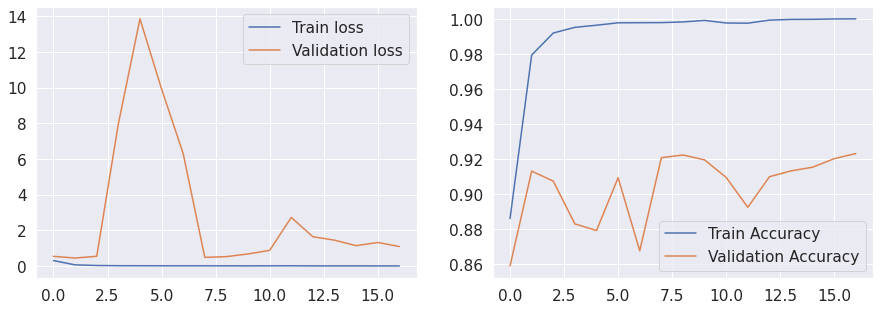

In [94]:
def plot_history(history,MODEL_DIR,iden):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
    ax_acc.legend()
    plt.savefig(os.path.join(MODEL_DIR,f"{iden}.png"))
    plt.show()

# show history
plot_history(history,MODEL_DIR,f"{MODEL_NAME}")

# Model Evaluation on pure testing

In [95]:
model.load_weights(WEIGHT_PATH)
result = model.evaluate(eval_ds,steps=EVAL_STEPS )
dict(zip(model.metrics_names, result))

56/56 [==============================] - 6s 97ms/step - loss: 0.4506 - accuracy: 0.9136


{'loss': 0.45056766271591187, 'accuracy': 0.913644015789032}

In [96]:
from tqdm.auto import tqdm
gts=[]
preds=[]

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred

gts=np.array(gts)
preds=np.array(preds)

  0%|          | 0/56 [00:00<?, ?it/s]

4/4 [==============================] - 1s 71ms/step


Exception ignored in: <function Executor.__del__ at 0x7f59f13f40d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [97]:
# from tqdm.auto import tqdm
# gts=[]
# preds=[]

# for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
#   y_pred=model.predict(x)
#   gt= list(np.argmax(y, axis=1))
#   pred=list(np.argmax(y_pred, axis=1))
#   gts+=gt
#   preds+=pred

# gts=np.array(gts)
# preds=np.array(preds


#     # calculate the fpr and tpr for all thresholds of the classification
#     probabilities = model.predict(np.array(gts))
#     predictions = probabilities[:, 1]
#     fpr, tpr, threshold = metrics.roc_curve(gts, preds)
#     roc_auc = metrics.auc(fpr, tpr)
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
#     plt.legend(loc='lower right')
#     plt.plot([0, 1], [0, 1], 'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()

In [98]:
# import numpy as np
# from sklearn import metrics
# from sklearn.metrics import roc_curve
# y_pred_keras = model.predict(x).ravel()
# fpr_keras, tpr_keras, thresholds_keras= roc_curve(gts, preds)

# from sklearn.metrics import auc
# auc_keras = auc(fpr_keras, tpr_keras)
# from tqdm.auto import tqdm
# gts=[]
# preds=[]

# for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
#   y_pred=model.predict(x)
#   gt= list(np.argmax(y, axis=1))
#   pred=list(np.argmax(y_pred, axis=1))
#   gts+=gt
#   preds+=pred

# gts=np.array(gts)
# preds=np.array(preds)
# y_pred = model.predict(x).ravel()

# scores = np.array(preds)
# fpr, tpr, thresholds = metrics.roc_curve(gts, preds, pos_label=9)
# roc_auc = metrics.auc(fpr, tpr)

# from sklearn.metrics import roc_curve

# fpr_keras, tpr_keras, thresholds_keras = roc_curve(gts, preds)

# from sklearn.metrics import auc
# auc_keras = auc(fpr_keras, tpr_keras)

# import matplotlib.pyplot as plt
# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_keras, tpr_keras, label='RF (area = {:.3f})'.format(auc_keras))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()
# plt.figure( os.path.join(MODEL_DIR,f"ROC_{MODEL_NAME}.png"))

In [99]:
from sklearn.metrics import classification_report
print(classification_report(gts, preds, target_names=LABELS))

              precision    recall  f1-score   support

    covid_19       0.48      0.59      0.53       231
      normal       0.95      0.83      0.88      2311
   pneumonia       0.98      0.96      0.97      2316
tuberculosis       0.88      0.98      0.93      2310

    accuracy                           0.91      7168
   macro avg       0.82      0.84      0.83      7168
weighted avg       0.92      0.91      0.91      7168



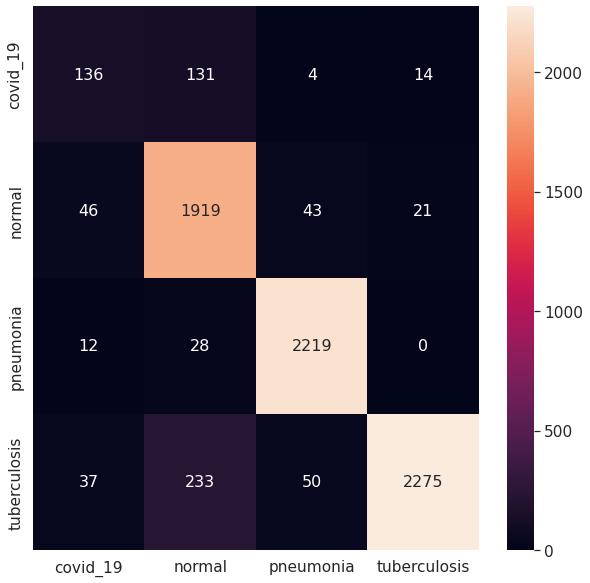

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
con_mat=confusion_matrix(preds, gts)
df_cm = pd.DataFrame(con_mat, 
                     index = LABELS,
                     columns = LABELS)
plt.figure(figsize = (10,10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
plt.savefig( os.path.join(MODEL_DIR,f"confusion_{MODEL_NAME}.png"))
plt.show()